<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2_Face_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Imports
---

In [ ]:
import uuid
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from datetime import datetime
from PIL import Image as pimg

---
# Funkcja do robienia zdjęć kamerą
---

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open("/content/faceImg/" + filename, 'wb') as f:
    f.write(binary)
  return filename

---
# Import datasetu z kaggle
---

In [ ]:
from google.colab import files
%cd /content
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d "shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset"
import zipfile
zip_ref = zipfile.ZipFile("detect-ai-generated-faces-high-quality-dataset.zip", 'r')
zip_ref.extractall('/content')
zip_ref.close()

/content


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset
License(s): apache-2.0
  0% 0.00/116M [00:00<?, ?B/s]
100% 116M/116M [00:00<00:00, 1.28GB/s]


In [ ]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
# Przygotowanie datasetu
---

In [ ]:
datasetPath = "/content/AI-face-detection-Dataset"

imgDim = (256, 256)
batchSize = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    label_mode='binary',
    seed=500,
    image_size=imgDim,
    batch_size=batchSize,
    shuffle=True
)

trainingSetSize = 0.8
validationgSetSize = 0.1

datasetSize = len(dataset)
trainBatches = int(datasetSize * trainingSetSize) + 1
validationBatches = int(datasetSize * validationgSetSize)
testingBatches = datasetSize - trainBatches - validationBatches

trainingSet = dataset.take(trainBatches)
validationSet = dataset.skip(trainBatches).take(validationBatches)
testingSet = dataset.skip(trainBatches + validationBatches)

trainingSet = trainingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
testingSet = testingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Testing set lenght:", len(testingSet))
print("Training classes: ", dataset.class_names)


Found 3203 files belonging to 2 classes.
Training set lenght: 81
Validation set lenght: 10
Testing set lenght: 10
Training classes:  ['AI', 'real']


---
# VGG16
---

In [ ]:
from threading import active_count
VGG16_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(*imgDim, 3),
    pooling="avg"
)

VGG16_base.trainable = True

input = tf.keras.Input(shape=(*imgDim, 3))

data_aug = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
])

x = data_aug(input)

x = VGG16_base(x, training=False)
x = BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True
)(x)
x = Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(0.001),
    bias_regularizer=regularizers.l2(0.001),
    activity_regularizer=regularizers.l1(0.001)
)(x)
x = Dropout(
    rate = .4,
    seed = 500
)(x)
x = Dense(
    64,
    activation="relu"
)(x)
output = Dense(1, activation="sigmoid")(x)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

VGG16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,864,577 (56.70 MB)

 Trainable params: 14,863,553 (56.70 MB)

 Non-trainable params: 1,024 (4.00 KB)

---
# Trenowanie
---

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

print("Starting trainging at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 50,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting trainging at 2025-05-18 12:32:09.665608
Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 629ms/step - accuracy: 0.6856 - loss: 1.6719 - precision: 0.7197 - recall: 0.8682 - val_accuracy: 0.8219 - val_loss: 1.1121 - val_precision: 0.8052 - val_recall: 0.9773
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 62s 581ms/step - accuracy: 0.7150 - loss: 0.8086 - precision: 0.7052 - recall: 0.9948 - val_accuracy: 0.9094 - val_loss: 0.8406 - val_precision: 0.9099 - val_recall: 0.9636
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 574ms/step - accuracy: 0.8838 - loss: 0.7181 - precision: 0.8747 - recall: 0.9654 - val_accuracy: 0.9031 - val_loss: 0.8161 - val_precision: 0.9355 - val_recall: 0.9227
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 578ms/step - accuracy: 0.9470 - loss: 0.6236 - precision: 0.9619 - recall: 0.9580 - val_accuracy: 0.6875 - val_loss: 1.3752 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 45s 553ms/step - accuracy: 0.9909 - loss: 0.4537 - precision: 0.9926 

In [ ]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plotMetrics(VGG16_history, "loss")
plotMetrics(VGG16_history, "accuracy")
plotMetrics(VGG16_history, "precision")
plotMetrics(VGG16_history, "recall")

---
# Sprawdzanie sieci
---

In [ ]:
loadedModel = tf.keras.models.load_model("VGG16-1-gen.keras")

In [ ]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 1.0000 - loss: 0.0278 - precision: 1.0000 - recall: 1.0000
Loss: 0.0273
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


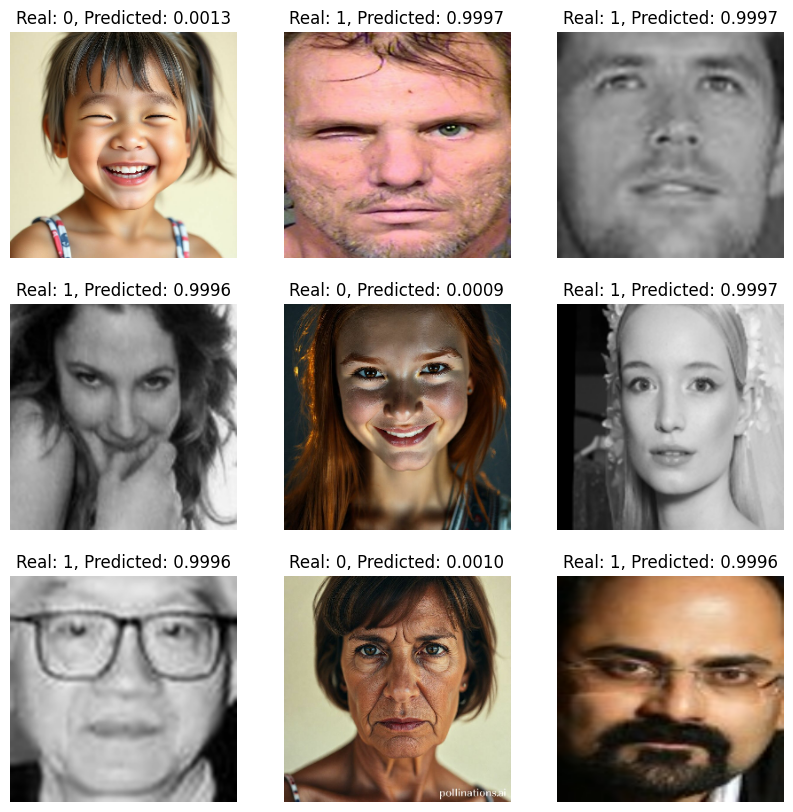

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        # plt.title(
        #     f"Type: {dataset.class_names[np.argmax(labels[i])]},"
        #     f"Predicted: {dataset.class_names[np.argmax(result)]}"
        # )
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")


mkdir: cannot create directory ‘/content/faceImg’: File exists


<IPython.core.display.Javascript object>

Saved to cc19764e.jpg


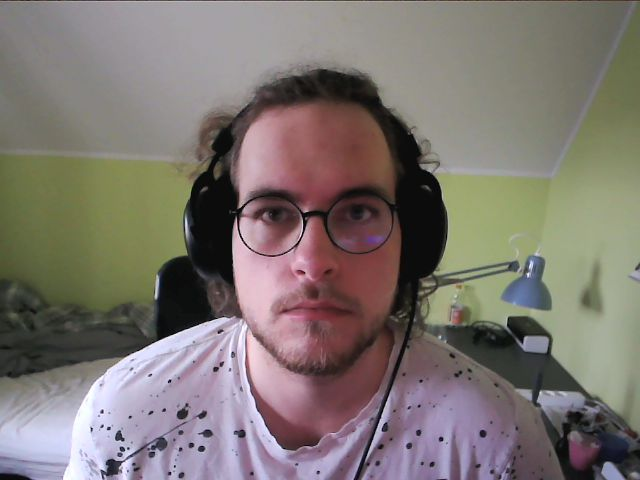

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


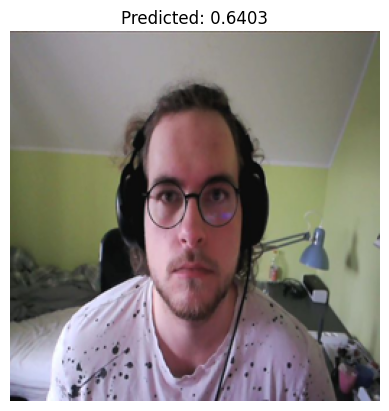

In [ ]:
from IPython.display import Image

!mkdir /content/faceImg

filename = None

try:
  filename = take_photo(filename=str(uuid.uuid4())[:8]+".jpg")
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image("/content/faceImg/" + filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

with pimg.open("/content/faceImg/" + filename) as img:
  res = img.resize(imgDim)
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
#   plt.title(f"Predicted: {dataset.class_names[np.argmax(result)]}")
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.axis("off")
  plt.show()


/content/uploadedImgs


Saving 20250414_204922.jpg to 20250414_204922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


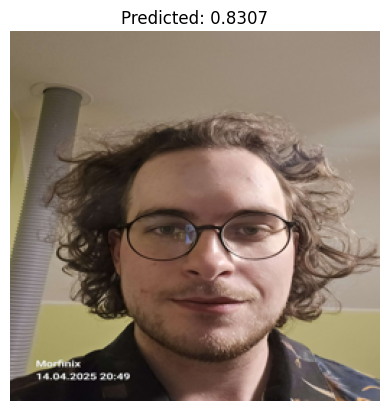

In [ ]:
!mkdir /content/uploadedImgs
%cd /content/uploadedImgs

uploaded = files.upload()
uploadedName = list(uploaded.keys())[0]

with pimg.open(uploadedName) as img:
    img = img.convert("RGB")
    res = img.resize(imgDim)
    result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
    # plt.title(
    #         f"Predicted: {dataset.class_names[np.argmax(result)]}"
    #     )
    plt.title(f"Predicted: {result[0 ,0]:.4f}")
    imgplot = plt.imshow(res)
    plt.axis("off")
    plt.show()
